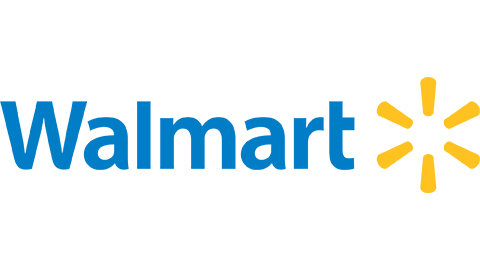

### How to forecast Walmart sales in the next 30 days?

#### The Dataset
The dataset, generously made available by Walmart, involves the sales of various products sold in the USA, organized in the form of grouped time series. More specifically, the dataset involves the sales of 30,075 products, classified in 3 product categories (Hobbies, Foods, and Household) and 7 product departments, in which the above-mentioned categories are disaggregated. The products are sold across 10 stores, located in 3 States (CA, TX, and WI). In this respect, the bottom-level of the hierarchy, i.e., product-store sales, can be mapped either across product categories or geographical regions. 

In this *__Capstone project__* , the dataset only includes stores of CA State and in Food Category due to the limited hardware resources, as follows:


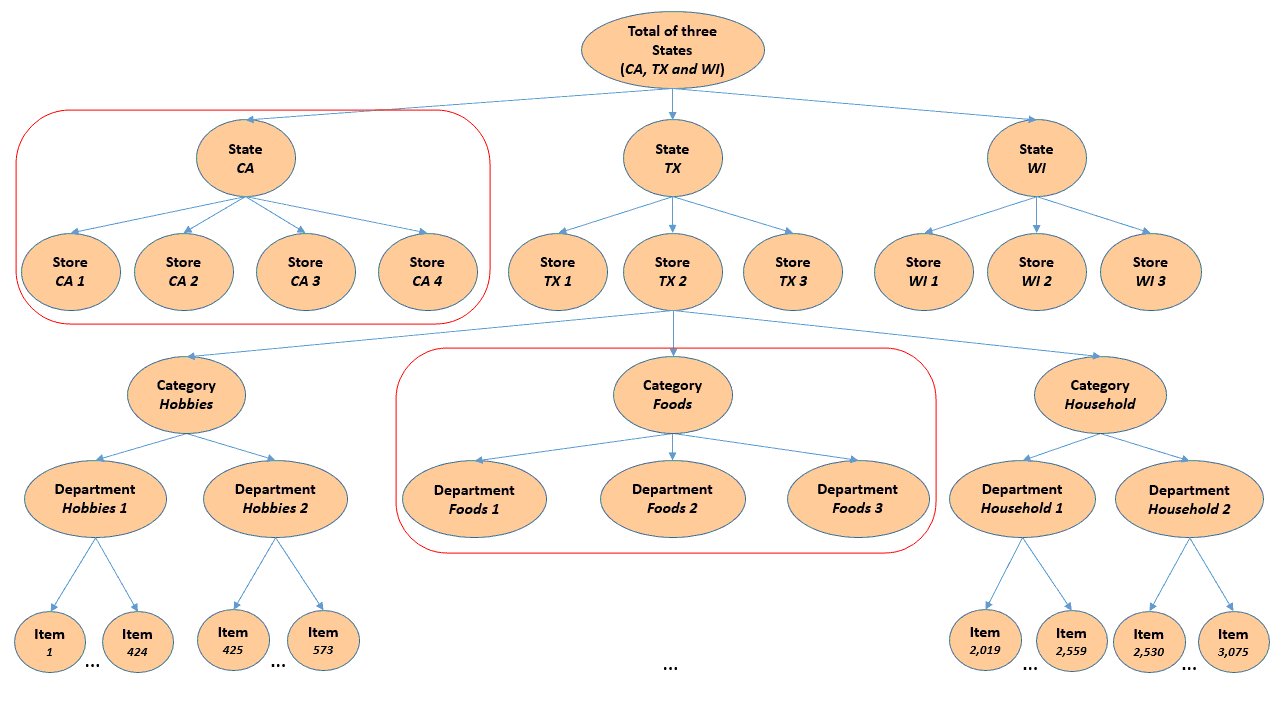

The historical data range from 2011-01-29 to 2016-05-22. Thus, the products have a (maximum) selling history of 1,941 days / 5.4 years (test data of h=28 days not included).

The M5 dataset consists of the following three (3) files:

- File 1: “calendar.csv”: 
    - Contains information about the dates the products are sold.
        - date: The date in a “y-m-d” format.
        - wm_yr_wk: The id of the week the date belongs to.
        - weekday: The type of the day (Saturday, Sunday, …, Friday).
        - wday: The id of the weekday, starting from Saturday.
        - month: The month of the date.
        - year: The year of the date.
        - d: day i, from 1 to 1941
        - event_name_1: If the date includes an event, the name of this event.
        - event_type_1: If the date includes an event, the type of this event.
        - event_name_2: If the date includes a second event, the name of this event.
        - event_type_2: If the date includes a second event, the type of this event.
        - snap_CA, snap_TX, and snap_WI: A binary variable (0 or 1) indicating whether the stores of CA, TX or WI  allow SNAP purchases on the examined date. 1 indicates that SNAP purchases are allowed.
    
    

- File 2: “sell_prices.csv”
    - Contains information about the price of the products sold per store and date.
        - store_id: The id of the store where the product is sold.
        - item_id: The id of the product.
        - wm_yr_wk: The id of the week.
        - sell_price: The price of the product for the given week/store. Price is provided per week (average across seven days). If not available, this means that the product was not sold during the examined week.



- File 3: “sales_train_evaluation.csv”
    - Contains the historical daily sales data per product and store.
        - item_id: The id of the product.
        - dept_id: The id of the department the product belongs to.
        - cat_id: The id of the category the product belongs to.
        - store_id: The id of the store where the product is sold.
        - state_id: The State where the store is located.
        - d_1, d_2, …, d_i, … d_1941: The number of products sold at day i, starting from 2011-01-29.

### 1. Load & Clean the data

In [1]:

# Import required modules
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import statsmodels.api as sm

sns.set_style("darkgrid")
mpl.rcParams['figure.figsize'] = (20,5)


In [2]:

# Read in the data
input_dir ='m5-forecasting-accuracy'
calendar  = pd.read_csv('{}/calendar.csv'.format(input_dir))
prices    = pd.read_csv('{}/sell_prices.csv'.format(input_dir))
sales     = pd.read_csv('{}/sales_train_evaluation.csv'.format(input_dir))


- Explore **Calendar dataframe** - Containing information about the dates the products are sold

In [3]:
calendar.head()

,date,wm_yr_wk,weekday,wday,month,year,d,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI
0,2011-01-29,11101,Saturday,1,1,2011,d_1,NaN,NaN,NaN,NaN,0,0,0
1,2011-01-30,11101,Sunday,2,1,2011,d_2,NaN,NaN,NaN,NaN,0,0,0
2,2011-01-31,11101,Monday,3,1,2011,d_3,NaN,NaN,NaN,NaN,0,0,0
3,2011-02-01,11101,Tuesday,4,2,2011,d_4,NaN,NaN,NaN,NaN,1,1,0
4,2011-02-02,11101,Wednesday,5,2,2011,d_5,NaN,NaN,NaN,NaN,1,0,1


In [4]:

# Replace missing values NaN in calendar dataframe by 'None'
calendar['event_name_1'].replace(np.nan, 'None', inplace=True)
calendar['event_type_1'].replace(np.nan, 'None', inplace=True)
calendar['event_name_2'].replace(np.nan, 'None', inplace=True)
calendar['event_type_2'].replace(np.nan, 'None', inplace=True)
calendar.head()


,date,wm_yr_wk,weekday,wday,month,year,d,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI
0,2011-01-29,11101,Saturday,1,1,2011,d_1,None,None,None,None,0,0,0
1,2011-01-30,11101,Sunday,2,1,2011,d_2,None,None,None,None,0,0,0
2,2011-01-31,11101,Monday,3,1,2011,d_3,None,None,None,None,0,0,0
3,2011-02-01,11101,Tuesday,4,2,2011,d_4,None,None,None,None,1,1,0
4,2011-02-02,11101,Wednesday,5,2,2011,d_5,None,None,None,None,1,0,1


In [5]:
calendar.dtypes

date            object
wm_yr_wk         int64
weekday         object
wday             int64
month            int64
year             int64
d               object
event_name_1    object
event_type_1    object
event_name_2    object
event_type_2    object
snap_CA          int64
snap_TX          int64
snap_WI          int64
dtype: object

- Explore **Sell prices dataframe** - Containing information about the price of the products sold per store and date

In [6]:
prices.head()

,store_id,item_id,wm_yr_wk,sell_price
0,CA_1,HOBBIES_1_001,11325,9.58
1,CA_1,HOBBIES_1_001,11326,9.58
2,CA_1,HOBBIES_1_001,11327,8.26
3,CA_1,HOBBIES_1_001,11328,8.26
4,CA_1,HOBBIES_1_001,11329,8.26


In [7]:
prices.dtypes

store_id       object
item_id        object
wm_yr_wk        int64
sell_price    float64
dtype: object

In [8]:

# Limit dataset belong to CA state and FOODS category
prices = prices[prices['store_id'].str.contains('CA')]
prices = prices[prices['item_id'].str.contains('FOODS')]
prices.head()


,store_id,item_id,wm_yr_wk,sell_price
368746,CA_1,FOODS_1_001,11101,2.0
368747,CA_1,FOODS_1_001,11102,2.0
368748,CA_1,FOODS_1_001,11103,2.0
368749,CA_1,FOODS_1_001,11104,2.0
368750,CA_1,FOODS_1_001,11105,2.0


- Explore **Sales dataframe** - Containing the historical daily sales data per product and store

In [9]:
sales.head()

,id,item_id,dept_id,cat_id,store_id,state_id,d_1,d_2,d_3,d_4,...,d_1932,d_1933,d_1934,d_1935,d_1936,d_1937,d_1938,d_1939,d_1940,d_1941
0,HOBBIES_1_001_CA_1_evaluation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,2,4,0,0,0,0,3,3,0,1
1,HOBBIES_1_002_CA_1_evaluation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,0,1,2,1,1,0,0,0,0,0
2,HOBBIES_1_003_CA_1_evaluation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,1,0,2,0,0,0,2,3,0,1
3,HOBBIES_1_004_CA_1_evaluation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,1,1,0,4,0,1,3,0,2,6
4,HOBBIES_1_005_CA_1_evaluation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,0,0,0,2,1,0,0,2,1,0


In [10]:
sales.dtypes

id          object
item_id     object
dept_id     object
cat_id      object
store_id    object
             ...  
d_1937       int64
d_1938       int64
d_1939       int64
d_1940       int64
d_1941       int64
Length: 1947, dtype: object

In [11]:

# Limit dataset belong to CA state and FOODS category
sales = sales[sales['state_id'] == 'CA']
sales = sales[sales['cat_id'] == 'FOODS']
sales.tail()


,id,item_id,dept_id,cat_id,store_id,state_id,d_1,d_2,d_3,d_4,...,d_1932,d_1933,d_1934,d_1935,d_1936,d_1937,d_1938,d_1939,d_1940,d_1941
12191,FOODS_3_823_CA_4_evaluation,FOODS_3_823,FOODS_3,FOODS,CA_4,CA,1,1,1,4,...,1,1,2,0,3,2,1,1,1,0
12192,FOODS_3_824_CA_4_evaluation,FOODS_3_824,FOODS_3,FOODS,CA_4,CA,0,0,0,1,...,1,0,1,0,0,2,0,4,0,0
12193,FOODS_3_825_CA_4_evaluation,FOODS_3_825,FOODS_3,FOODS,CA_4,CA,2,3,2,1,...,1,0,1,1,0,2,1,1,1,0
12194,FOODS_3_826_CA_4_evaluation,FOODS_3_826,FOODS_3,FOODS,CA_4,CA,0,0,0,0,...,1,2,2,2,2,2,0,2,2,4
12195,FOODS_3_827_CA_4_evaluation,FOODS_3_827,FOODS_3,FOODS,CA_4,CA,0,0,0,0,...,1,8,2,16,4,3,4,5,4,0


### 2. Reduce Pandas dataframe size
The error would happend if I try to merge 03 dataframes - calendar, prices and sales - without reducing the dataframe sizes. In this step, I will reduce the amount of storage in each dataframe to optimize its size. For example, with column having a range of value from 0 to 127, I will reassign this column to the datatype **int8** instead of default value **int64** to reduce the memory size. 

I list out some datatypes with the values and memory used:

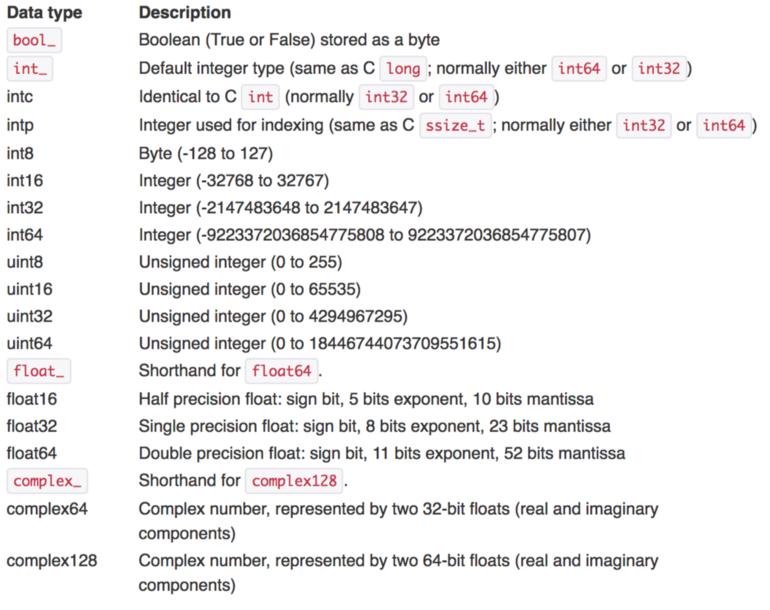

https://docs.scipy.org/doc/numpy-1.13.0/user/basics.types.html

In [12]:

# Calculate how much memory a dataframe take in MB
def memory_usage(df):
    return round(df.memory_usage(deep=True).sum() / (1024 ** 2), 2)


# Memory used by calendar, prices and sales
print('Memory used by calendar:', memory_usage(calendar), 'MB')
print('Memory used by prices:', memory_usage(prices), 'MB')
print('Memory used by sales:', memory_usage(sales), 'MB')


Memory used by calendar: 1.07 MB
Memory used by prices: 182.89 MB
Memory used by sales: 87.35 MB


In [13]:

# Create a downcast function to reduce memory size for int and float datatype
def downcast(df):
    cols = df.dtypes.index.tolist()
    types = df.dtypes.values.tolist()
    for i, t in enumerate(types):
        # Check a range of values in the column and find a suitable datatype to assign for
        # For integer
        if 'int' in str(t):
            if df[cols[i]].min() > np.iinfo('int8').min and df[cols[i]].max() < np.iinfo('int8').max:
                df[cols[i]] = df[cols[i]].astype('int8')
            elif df[cols[i]].min() > np.iinfo('int16').min and df[cols[i]].max() < np.iinfo('int16').max:
                df[cols[i]] = df[cols[i]].astype('int16')
            elif df[cols[i]].min() > np.iinfo('int32').min and df[cols[i]].max() < np.iinfo('int32').max:
                df[cols[i]] = df[cols[i]].astype('int32')
            else: 
                df[cols[i]] = df[cols[i]].astype('int64')
        
        # Check a range of values in the column and find a suitable datatype to assign for
        # For float
        elif 'float' in str(t):
            if df[cols[i]].min() > np.finfo('float16').min and df[cols[i]].max() < np.finfo('float16').max:
                df[cols[i]] = df[cols[i]].astype('float16')
            elif df[cols[i]].min() > np.finfo('float32').min and df[cols[i]].max() < np.finfo('float32').max:
                df[cols[i]] = df[cols[i]].astype('float32')
            else:
                df[cols[i]] = df[cols[i]].astype('float64')
    
    return df      
              
    

In [14]:

# Downcast dataframe
calendar = downcast(calendar)
prices = downcast(prices)
sales = downcast(sales)

print('Memory used by calendar:', memory_usage(calendar), 'MB')
print('Memory used by prices:', memory_usage(prices), 'MB')
print('Memory used by sales:', memory_usage(sales), 'MB')



Memory used by calendar: 0.98 MB
Memory used by prices: 168.55 MB
Memory used by sales: 18.88 MB


### 3. Merge data
Merging all 03 dataframes sales, calendar and prices into 01 dataframe named df to make it easy for the exploration.

In [15]:

# Convert sales dataframe from wide format to long format, and rename to df
df = sales.melt(id_vars=['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id'], value_name='units')
df.head()


,id,item_id,dept_id,cat_id,store_id,state_id,variable,units
0,FOODS_1_001_CA_1_evaluation,FOODS_1_001,FOODS_1,FOODS,CA_1,CA,d_1,3
1,FOODS_1_002_CA_1_evaluation,FOODS_1_002,FOODS_1,FOODS,CA_1,CA,d_1,0
2,FOODS_1_003_CA_1_evaluation,FOODS_1_003,FOODS_1,FOODS,CA_1,CA,d_1,0
3,FOODS_1_004_CA_1_evaluation,FOODS_1_004,FOODS_1,FOODS,CA_1,CA,d_1,0
4,FOODS_1_005_CA_1_evaluation,FOODS_1_005,FOODS_1,FOODS,CA_1,CA,d_1,3


In [16]:

# Merge all the dataframe into one dataframe named df
df = pd.merge(df, calendar, left_on='variable', right_on='d')
df = pd.merge(df, prices, on=['item_id', 'store_id', 'wm_yr_wk'])

# Create a sales column in a df dataframe
df['sales'] = df['units'] * df['sell_price']
df.tail()


,id,item_id,dept_id,cat_id,store_id,state_id,variable,units,date,wm_yr_wk,...,d,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI,sell_price,sales
8584342,FOODS_3_825_CA_4_evaluation,FOODS_3_825,FOODS_3,FOODS,CA_4,CA,d_1941,0,2016-05-22,11617,...,d_1941,None,None,None,None,0,0,0,3.980469,0.000000
8584343,FOODS_3_826_CA_4_evaluation,FOODS_3_826,FOODS_3,FOODS,CA_4,CA,d_1940,2,2016-05-21,11617,...,d_1940,None,None,None,None,0,0,0,1.280273,2.560547
8584344,FOODS_3_826_CA_4_evaluation,FOODS_3_826,FOODS_3,FOODS,CA_4,CA,d_1941,4,2016-05-22,11617,...,d_1941,None,None,None,None,0,0,0,1.280273,5.121094
8584345,FOODS_3_827_CA_4_evaluation,FOODS_3_827,FOODS_3,FOODS,CA_4,CA,d_1940,4,2016-05-21,11617,...,d_1940,None,None,None,None,0,0,0,1.000000,4.000000
8584346,FOODS_3_827_CA_4_evaluation,FOODS_3_827,FOODS_3,FOODS,CA_4,CA,d_1941,0,2016-05-22,11617,...,d_1941,None,None,None,None,0,0,0,1.000000,0.000000


In [17]:

# Saving the dataframe
df.to_csv('walmart.csv')


### 4. Exploratory Data Analysis

In this session, I try to answer these questions:

- What is the trend of sales by stores?
- What is the trend of sales by departments?
- What are the different between sales on weekend and weekdays, daily sales with and without SNAP program?
- Which event type has the highest median in daily sales?

#### 4.1 Understanding sales at stores and departements


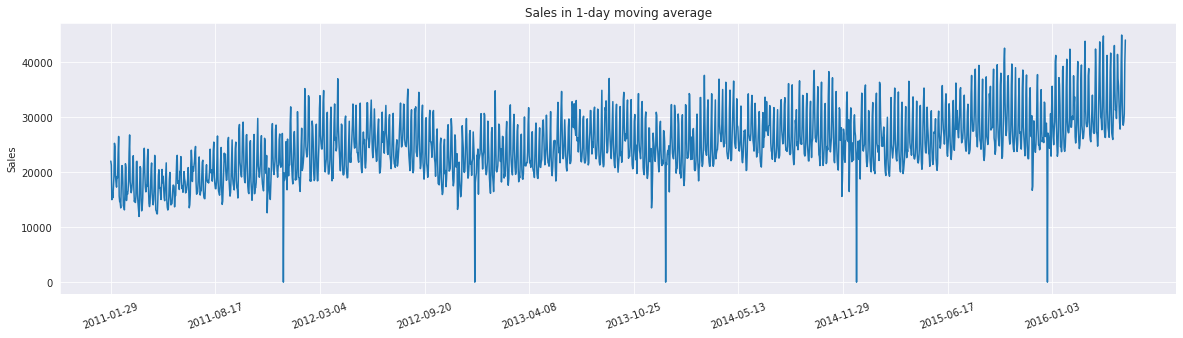

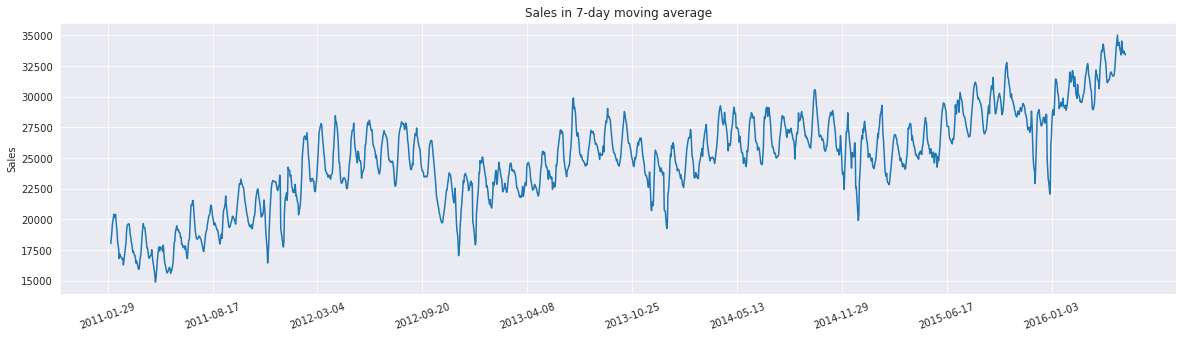

In [95]:

# Plot sales of stores on the same figure
def plot_sales(df, days):    
    df = df[['date', 'sales']].groupby('date').sum().rolling(days).mean()
    plt.plot(df.index, df['sales'])
        
    # Choose some tick marks to be displayed on x-axis
    plt.xticks(np.arange(0, 1990, step=200), rotation=20)
    plt.ylabel('Sales')  
    plt.title('Sales in {}-day moving average'.format(days))
    plt.show()

# Sales by CA stores
plot_sales(df, days=1)
plot_sales(df, days=7)


Now, I will drill down and examine the trend of sales by CA stores in the period from 2011-01-29 to 2016-05-22. The charts will be drawn in daily timeline and 7-day moving average.


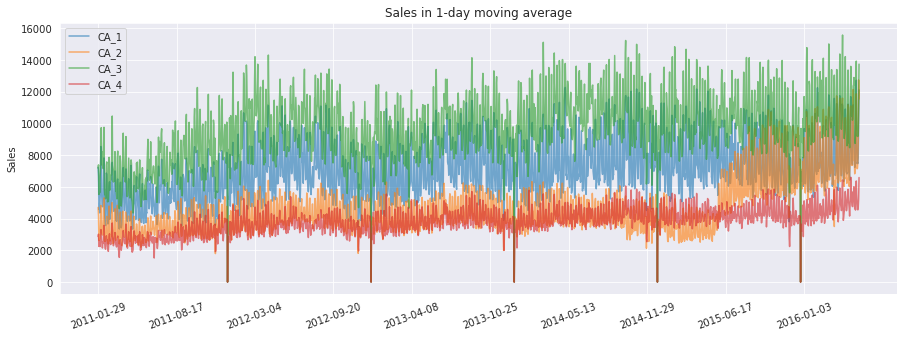

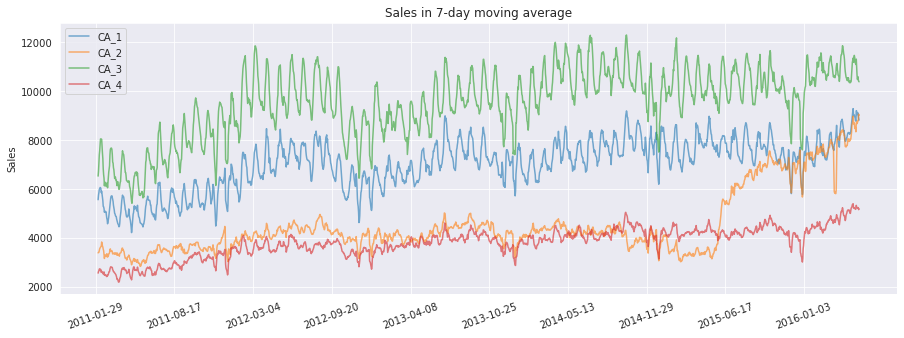

In [19]:

# Plot sales of stores on the same figure
def plot_sales_store(df, store_list, days):
    
    plt.figure(figsize=(15,5))
    
    for store in store_list:
        df_store = df[df['store_id'] == store]
        df_store = df_store[['date', 'sales']].groupby('date').sum().rolling(days).mean()
        plt.plot(df_store.index, df_store['sales'], label=store, alpha=0.6)
        
    # Choose some tick marks to be displayed on x-axis
    plt.xticks(np.arange(0, 1990, step=200), rotation=20)
    plt.ylabel('Sales')
    plt.legend(loc='best')
    plt.title('Sales in {}-day moving average'.format(days))
    plt.show()

    
# Store list    
store_list = ['CA_1', 'CA_2', 'CA_3', 'CA_4']

# Sales by CA stores
plot_sales_store(df, store_list, days=1)
plot_sales_store(df, store_list, days=7)


Next, I will drill down to each CA store and examine the trend of sales by Food departments. The charts will be drawn in 7-day moving average in the period from 2011-01-29 to 2016-05-22.

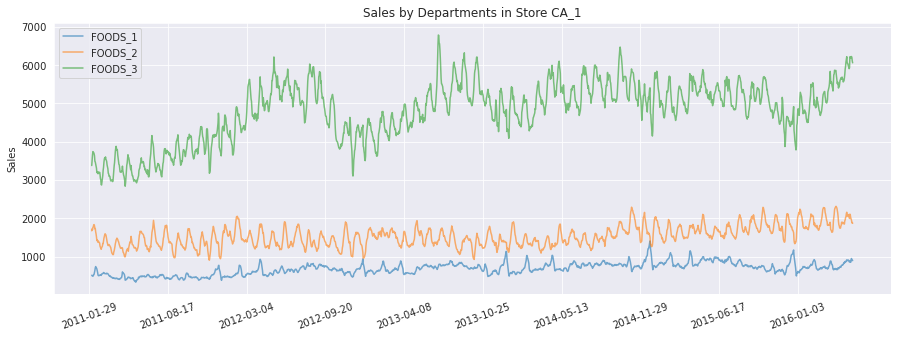

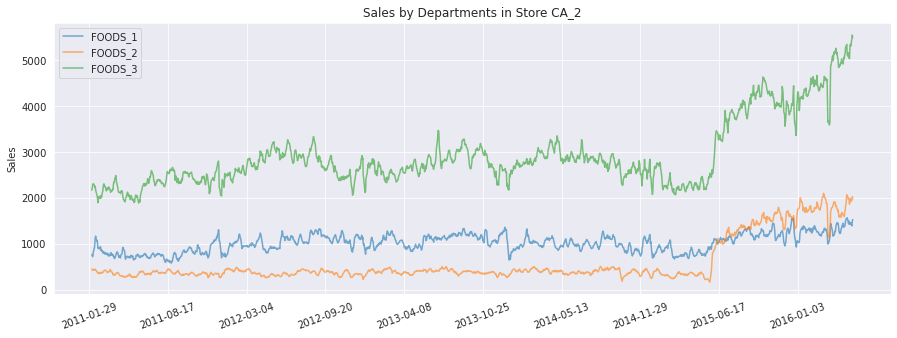

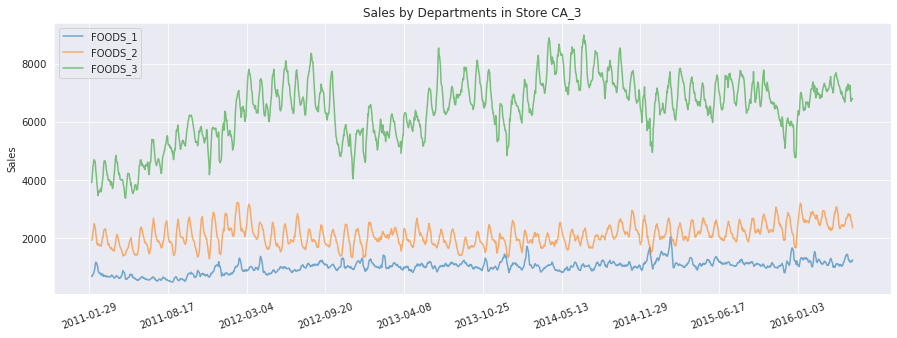

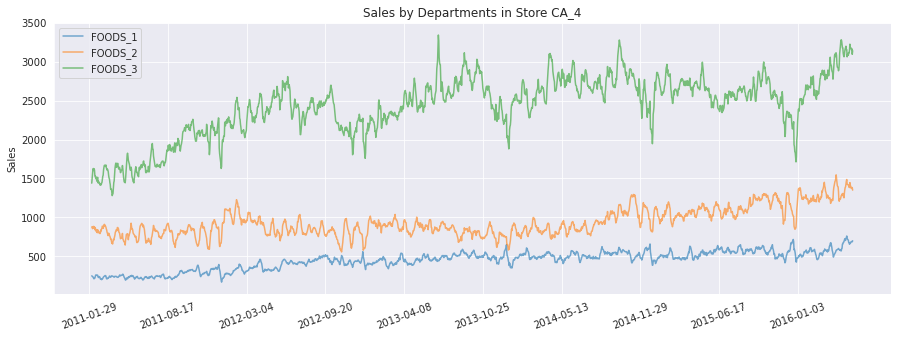

In [75]:

# Plot sales of departments on the same figure
def plot_sales_dept(df, store_id, dept_list, days):
    
    plt.figure(figsize=(15,5))
    
    df_store = df[df['store_id'] == store_id]    
    for dept in dept_list:
        df_dept = df_store[df_store['dept_id'] == dept]
        df_dept = df_dept[['date', 'sales']].groupby('date').sum().rolling(days).mean()
        plt.plot(df_dept.index, df_dept['sales'], label=dept, alpha=0.6)
        
    # Choose some tick marks to be displayed on x-axis
    plt.xticks(np.arange(0, 1990, step=200), rotation=20)
    plt.ylabel('Sales')
    plt.legend(loc='best')
    plt.title('Sales by Departments in Store {}'.format(store_id))
    plt.show()


# Store list & Department list
store_list = ['CA_1', 'CA_2', 'CA_3', 'CA_4']    
dept_list = ['FOODS_1', 'FOODS_2', 'FOODS_3']


# Sales by Departments in 7-day moving average
for store in store_list:    
    plot_sales_dept(df, store, dept_list, days=7)  
    

**Insights:**
- The sales are in an upward trend in the period 01/2011 - 05/2016. Sales increased 7.3% from 2013 to 2014 and 4% from 2014 to 2015. Sales in the first 05 months in 2016 increased sharply 22.9% compared to 2015.
- Sales in store CA_2 increased sharply from 05/2015, almost from FOODS_3 and FOODS_2 departments, and contributed up to 23.54% of total sales in 01 year after that.

#### 4.2 Using Boxplot to analyze overall sales by weekdays, months & holidays

In [89]:
# Using groupby() to group sales of all product items by date, departments, stores...
df_store = df[['date', 'store_id', 'weekday', 'snap_CA', 'event_type_1', 'event_type_2', 
               'sales']].groupby(['date', 'store_id', 'weekday', 'snap_CA', 
                                  'event_type_1', 'event_type_2']).sum() 

df_store.head()

sales
date       store_id weekday  snap_CA event_type_1 event_type_2             
2011-01-29 CA_1     Saturday 0       None         None          7241.104492
           CA_2     Saturday 0       None         None          4712.357422
           CA_3     Saturday 0       None         None          7191.396484
           CA_4     Saturday 0       None         None          2875.868164
2011-01-30 CA_1     Sunday   0       None         None          6705.852539

In [90]:

# Reset index of df_model
df_store = df_store.reset_index()
df_store.head()


,date,store_id,weekday,snap_CA,event_type_1,event_type_2,sales
0,2011-01-29,CA_1,Saturday,0,None,None,7241.104492
1,2011-01-29,CA_2,Saturday,0,None,None,4712.357422
2,2011-01-29,CA_3,Saturday,0,None,None,7191.396484
3,2011-01-29,CA_4,Saturday,0,None,None,2875.868164
4,2011-01-30,CA_1,Sunday,0,None,None,6705.852539


##### 4.2.1 Analyze a specific store: CA_1

In [91]:
store_var = 'CA_1'
df_store_var = df_store[df_store['store_id'] == store_var]
df_store_var.head()

,date,store_id,weekday,snap_CA,event_type_1,event_type_2,sales
0,2011-01-29,CA_1,Saturday,0,None,None,7241.104492
4,2011-01-30,CA_1,Sunday,0,None,None,6705.852539
8,2011-01-31,CA_1,Monday,0,None,None,4585.052734
12,2011-02-01,CA_1,Tuesday,1,None,None,4965.716797
16,2011-02-02,CA_1,Wednesday,1,None,None,4368.290039


In [92]:

# Define a function to plot a grahp
def plot_sales(dataframe, x_value, y_value):
    sns.boxplot(x=x_value, y=y_value, data=dataframe)
    plt.title('Overall Sales')
    plt.show()
    

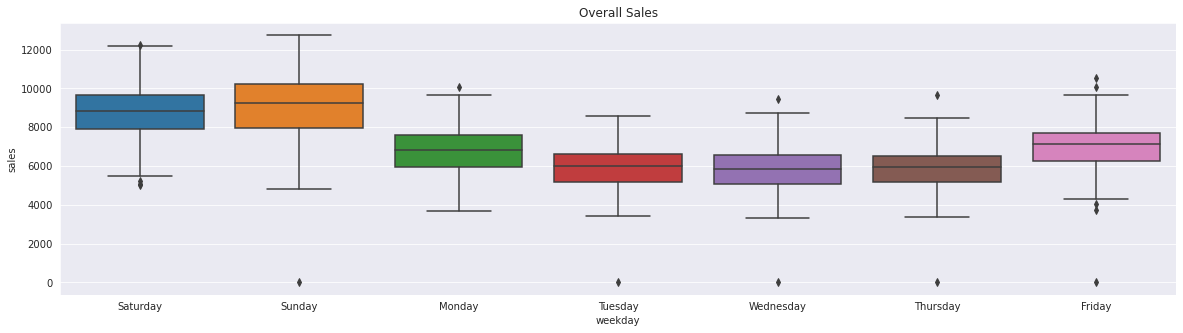

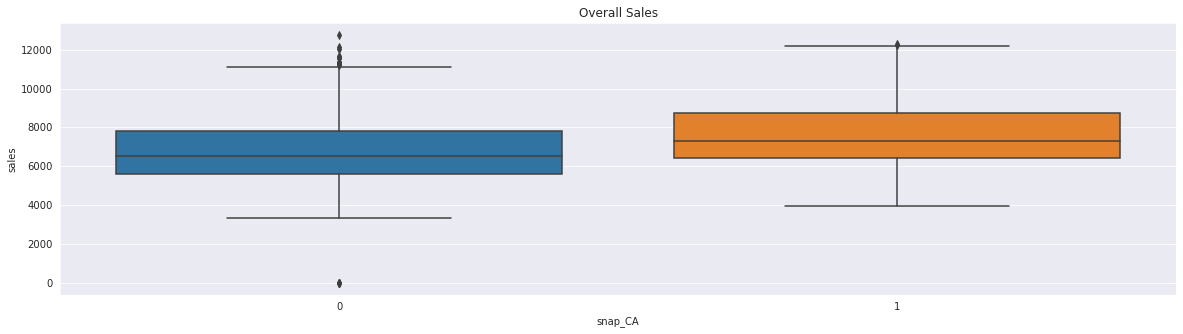

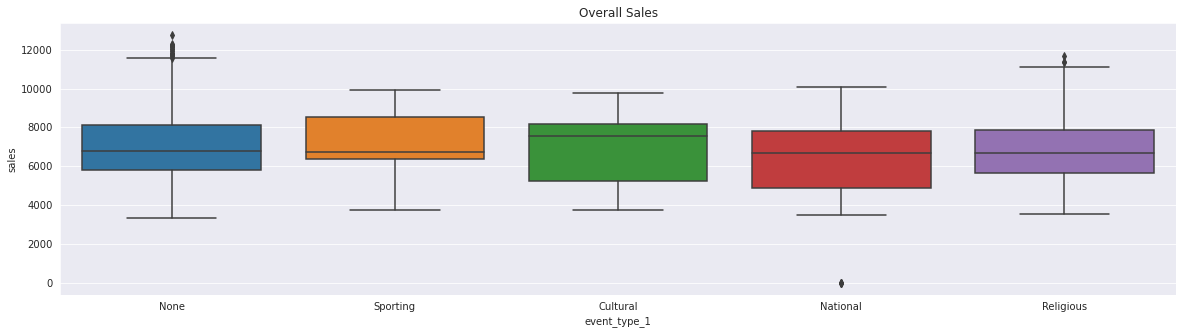

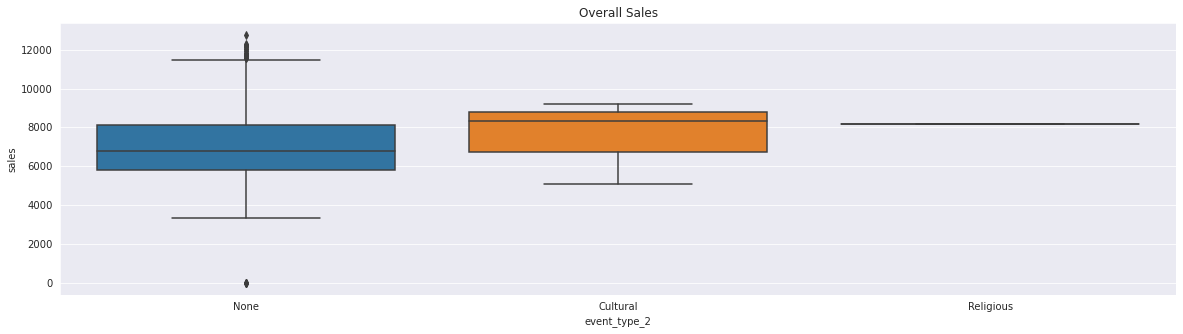

In [94]:
# Box plot of sales by weekday
plot_sales(df_store_var, x_value='weekday', y_value='sales')

# Box plot of sales by snap_CA
plot_sales(df_store_var, x_value='snap_CA', y_value='sales')

# Box plot of sales by weekday
plot_sales(df_store_var, x_value='event_type_1', y_value='sales')

# Box plot of sales by weekday
plot_sales(df_store_var, x_value='event_type_2', y_value='sales')

**Insights for store CA_1:** 
- Sales on Sunday were reported highest with a median 9.2K dollars, then Saturday with 8.8K dollars. Sales on Monday and Friday also had higher median than the rest of the week.
- Sales on days with a snap program were higher than days without this program.
- Daily sales on cultural event type has the highest median with more than $7.5K.


### 5. Inferential Statistical Analysis

#### 5.1. Create a heatmap
In this sub-session, I'll create a Seaborn heatmap to show correlations for all variables using the df_store dataset. However, corr() function only works with numerical data, so I need to transfrom some categorical variables to numerical variables. 

In [79]:

event_type_1 = ['None', 'Sporting', 'Cultural', 'National', 'Religious']
event_type_2 = ['None', 'Cultural', 'Religious']

# Transform 'event_type_1' variable
# Replace None with 0 and other events with 1
for event in event_type_1:
    if event != 'None':
        df_store['event_type_1'].replace(event, 1, inplace=True )
    else:
        df_store['event_type_1'].replace(event, 0, inplace=True )

            

# Transform 'event_type_2' variable
# Replace None with 0 and other events with 1 
for event in event_type_2:
    if event != 'None':
        df_store['event_type_2'].replace(event, 1, inplace=True )
    else:
        df_store['event_type_2'].replace(event, 0, inplace=True )


# Add weekday_dummy variable
df_store['weekday_dummy'] = np.where((df_store['weekday'] == 'Saturday') | 
                                     (df_store['weekday'] == 'Sunday'), 1, 0)

df_store.head()

,date,store_id,weekday,snap_CA,event_type_1,event_type_2,sales,weekday_dummy
0,2011-01-29,CA_1,Saturday,0,0,0,7241.104492,1
1,2011-01-29,CA_2,Saturday,0,0,0,4712.357422,1
2,2011-01-29,CA_3,Saturday,0,0,0,7191.396484,1
3,2011-01-29,CA_4,Saturday,0,0,0,2875.868164,1
4,2011-01-30,CA_1,Sunday,0,0,0,6705.852539,1


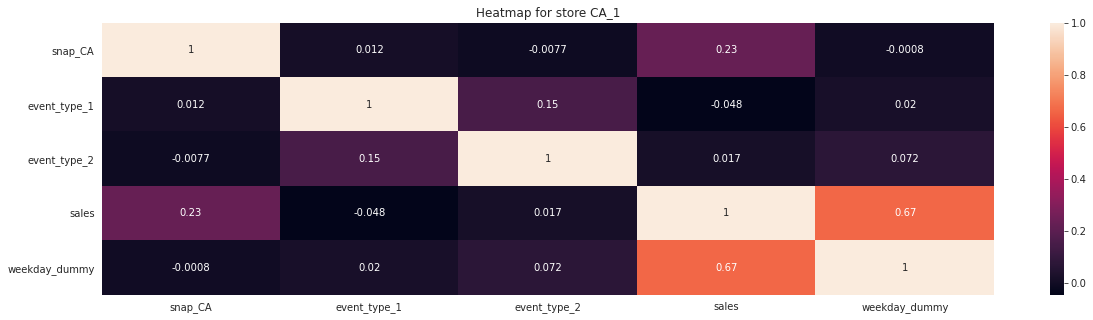

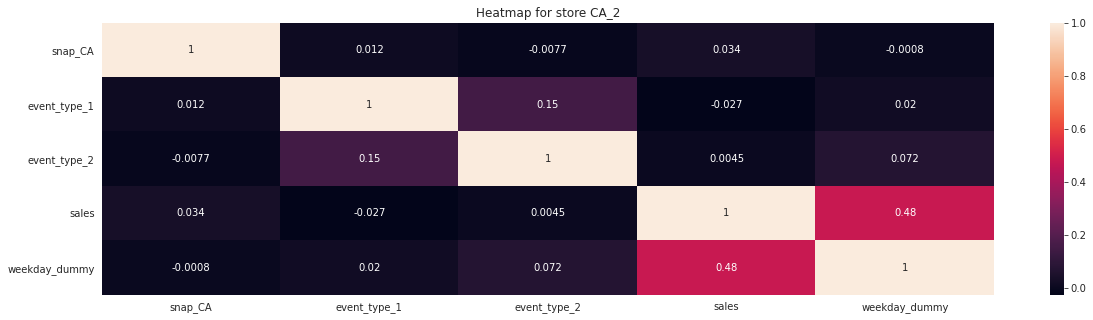

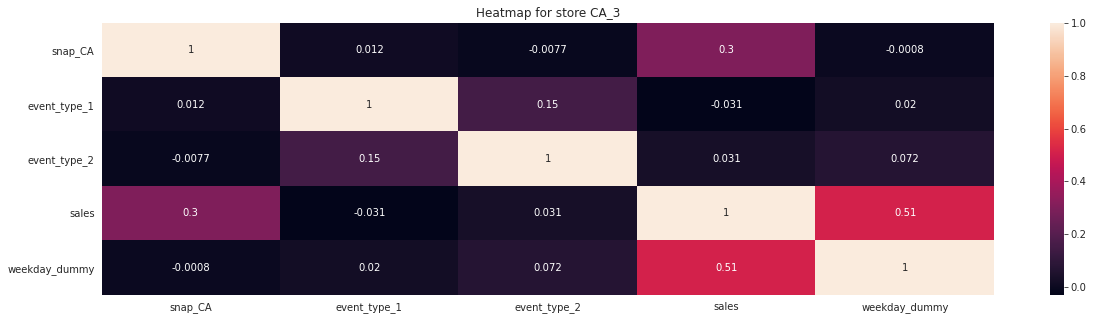

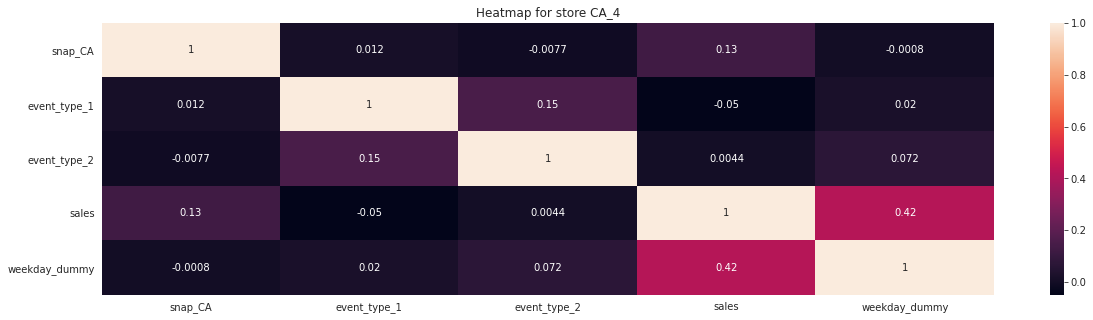

In [80]:

# Store list 
store_list = ['CA_1', 'CA_2', 'CA_3', 'CA_4']  

for store in store_list:
    df_model = df_store[df_store['store_id'] == store]
    
    # Create a heatmap to show the correlations for all variables
    correlated_dataframe = df_model.corr()
    sns.heatmap(correlated_dataframe, annot=True)
    plt.title('Heatmap for store {}'.format(store))
    plt.show()


#### 5.2. Modeling - Using OLS Regression
Using the OLS Regression Model in the statsmodel.api library, create a regression equation that models the sales (Y-Variable) against all independent variables in the df_model dataset.

In [81]:

store='CA_1'
df_model = df_store[df_store['store_id'] == store]
df_model.head()
    
# Create Independent Dataframe
independent_variables = df_model[['weekday_dummy', 'snap_CA', 'event_type_1', 'event_type_2']]
    
# Add a constant to Independent Dataframe
independent_variables = sm.add_constant(independent_variables)
    
# Create Dependent Dataframe
dependent_variable = df_model['sales'] 
    
# Store and Fit the model
regression_model = sm.OLS(dependent_variable, independent_variables).fit()
regression_model.summary() 



<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  sales   R-squared:                       0.501
Model:                            OLS   Adj. R-squared:                  0.500
Method:                 Least Squares   F-statistic:                     485.1
Date:                Sun, 23 May 2021   Prob (F-statistic):          6.79e-290
Time:                        16:50:46   Log-Likelihood:                -16624.
No. Observations:                1941   AIC:                         3.326e+04
Df Residuals:                    1936   BIC:                         3.328e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const          6006.4631     40.483    148.370      0.000    5927.068    6085.858
weekday_dummy  2656.2250     63.929     41.550      0.000    2530.848    2781.602
snap_CA         873.9976     61.326     14.252      0.000     753.726     994.269
event_type_1   -397.0484    106.682     -3.722      0.000    -606.272    -187.824
event_type_2   -788.9342    644.792     -1.224      0.221   -2053.494     475.626
==============================================================================
Omnibus:                       97.012   Durbin-Watson:                   0.806
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              179.087
Skew:                          -0.370   Prob(JB):                     1.29e-39
Kurtosis:                       4.291   Cond. No.                         24.9
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [82]:

store='CA_2'
df_model = df_store[df_store['store_id'] == store]
df_model.head()
    
# Create Independent Dataframe
independent_variables = df_model[['weekday_dummy', 'snap_CA', 'event_type_1', 'event_type_2']]
    
# Add a constant to Independent Dataframe
independent_variables = sm.add_constant(independent_variables)
    
# Create Dependent Dataframe
dependent_variable = df_model['sales'] 
    
# Store and Fit the model
regression_model = sm.OLS(dependent_variable, independent_variables).fit()
regression_model.summary() 


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  sales   R-squared:                       0.234
Model:                            OLS   Adj. R-squared:                  0.232
Method:                 Least Squares   F-statistic:                     147.6
Date:                Sun, 23 May 2021   Prob (F-statistic):          2.80e-110
Time:                        16:50:47   Log-Likelihood:                -16877.
No. Observations:                1941   AIC:                         3.376e+04
Df Residuals:                    1936   BIC:                         3.379e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const          4003.5098     46.121     86.804      0.000    3913.057    4093.962
weekday_dummy  1762.1945     72.832     24.195      0.000    1619.357    1905.032
snap_CA         122.2276     69.866      1.749      0.080     -14.794     259.249
event_type_1   -199.9873    121.540     -1.645      0.100    -438.350      38.375
event_type_2   -901.5105    734.591     -1.227      0.220   -2342.184     539.163
==============================================================================
Omnibus:                      569.851   Durbin-Watson:                   0.302
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1471.604
Skew:                           1.571   Prob(JB):                         0.00
Kurtosis:                       5.886   Cond. No.                         24.9
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [83]:

store='CA_3'
df_model = df_store[df_store['store_id'] == store]
df_model.head()
    
# Create Independent Dataframe
independent_variables = df_model[['weekday_dummy', 'snap_CA', 'event_type_1', 'event_type_2']]
    
# Add a constant to Independent Dataframe
independent_variables = sm.add_constant(independent_variables)
    
# Create Dependent Dataframe
dependent_variable = df_model['sales'] 
    
# Store and Fit the model
regression_model = sm.OLS(dependent_variable, independent_variables).fit()
regression_model.summary() 

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  sales   R-squared:                       0.355
Model:                            OLS   Adj. R-squared:                  0.353
Method:                 Least Squares   F-statistic:                     266.0
Date:                Sun, 23 May 2021   Prob (F-statistic):          2.48e-182
Time:                        16:50:47   Log-Likelihood:                -17087.
No. Observations:                1941   AIC:                         3.418e+04
Df Residuals:                    1936   BIC:                         3.421e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const          8484.8625     51.399    165.078      0.000    8384.059    8585.666
weekday_dummy  2274.2314     81.167     28.019      0.000    2115.047    2433.415
snap_CA        1285.2371     77.862     16.507      0.000    1132.535    1437.939
event_type_1   -332.3009    135.449     -2.453      0.014    -597.941     -66.660
event_type_2    165.5389    818.658      0.202      0.840   -1440.005    1771.083
==============================================================================
Omnibus:                      235.286   Durbin-Watson:                   0.595
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              484.332
Skew:                          -0.743   Prob(JB):                    6.74e-106
Kurtosis:                       4.945   Cond. No.                         24.9
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [ ]:

store='CA_4'
df_model = df_store[df_store['store_id'] == store]
df_model.head()
    
# Create Independent Dataframe
independent_variables = df_model[['weekday_dummy', 'snap_CA', 'event_type_1', 'event_type_2']]
    
# Add a constant to Independent Dataframe
independent_variables = sm.add_constant(independent_variables)
    
# Create Dependent Dataframe
dependent_variable = df_model['sales'] 
    
# Store and Fit the model
regression_model = sm.OLS(dependent_variable, independent_variables).fit()
regression_model.summary() 

**Insights:**
- **Limitation**: Linear regression model can not be used to explain "sales" variable. R-squared values in modelling for 04 stores (CA_1, CA_2, CA_3 & CA_4) are low, so the strength of relationships between dependent variable (sales) and independent variables (weekday_dummy, snap_CA, event_type_1 & event_type_2) are weak or low effect. 

- **Suggestion**: Using advance technique like machine learning to improve forecast accuracy
